<a href="https://colab.research.google.com/github/AntonyBoza/NATURAL-LANGUAGE-PROCESSING/blob/master/DistilBERT_Fine_Tuning_Emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VenApp Cases Multi-label classification with BERT

Ref: https://data4thought.com/toxic_comments_transformer.html

In [ ]:
!pip install -q transformers > /dev/null

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np  
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, average_precision_score
from time import time

pd.set_option("display.precision", 3)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

In [ ]:
import transformers
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, \
    DistilBertConfig, DistilBertTokenizerFast

In [ ]:
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [ ]:
# Cargamos el Google Drive para almacenar los archivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FOLDER_PATH = r"/content/drive/MyDrive/VENAPP_CLASIF_CASOS/"

In [ ]:
file = FOLDER_PATH+"dataset_venapp_one-hot.csv"

In [ ]:
dataset = pd.read_csv(file)
dataset.sample(3)

,text,Agua-Atenciones de instalaciones y equipos,Agua-Atención inmediata de agua potable,Agua-Atención inmediata de aguas servidas,Agua-Ciclos de Abastecimiento,Agua-Otros A,Agua-Proyectos mayores,Educación-Administrativo (Casos colectivos),Educación-Administrativo (Casos personales),Educación-Infraestructura E,...,Telecomunicaciones-Falla TDA,Telecomunicaciones-Instalación de línea e internet,Telecomunicaciones-Mudanza de línea,Telecomunicaciones-Reclamo de facturación,Telecomunicaciones-Registro ABA,Transporte-Afectación de vialidad,Transporte-Combustible,Transporte-Deterioro de unidades de transporte superficial,Transporte-Déficit de unidades de transporte superficial,Transporte-Mal funcionamiento o vandalismo en los sistemas de transporte
6753,operativo gas robaron bombona mediana nunca de...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14037,grupo q funciona ilegal hijos d bloqueron cobr...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11933,buenas tardes haciendo reporte falta internet ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
texts = list(dataset["text"])
label_names = dataset.drop(["text"], axis=1).columns
labels = dataset[label_names].values

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42)

In [ ]:
sample_idx = 120
print(f'Sample: "{train_texts[sample_idx]}"')
print(f"Labels: {pd.Series(train_labels[sample_idx], label_names).to_dict()}")

Sample: "final av arismendi dinde encuentra escuela san vicente final callejon hace falta buena asfaltada tambien estan afectados linea camionetas"
Labels: {'Agua-Atenciones de instalaciones y equipos': 0, 'Agua-Atención inmediata de agua potable': 0, 'Agua-Atención inmediata de aguas servidas': 0, 'Agua-Ciclos de Abastecimiento': 0, 'Agua-Otros A': 0, 'Agua-Proyectos mayores': 0, 'Educación-Administrativo (Casos colectivos)': 0, 'Educación-Administrativo (Casos personales)': 0, 'Educación-Infraestructura E': 0, 'Electricidad-Alumbrado público': 0, 'Electricidad-Falla de Servicio Eléctrico': 0, 'Electricidad-Otros': 0, 'Electricidad-Pica y Poda': 0, 'Electricidad-Proyecto de Electrificación': 0, 'Electricidad-Transformador': 0, 'Gas-Ciclos de Atención': 0, 'Gas-Conexión a Gasificación Directa': 0, 'Gas-Fuga de gas': 0, 'Gas-Sustitución de bombonas o tanques estacionarios': 0, 'Huracanes, Tormentas Tropicales-Ayuda Damnificados por Lluvia, daños en general y a infraestructura': 0, 'Metr

### Exploratory Data Analysis

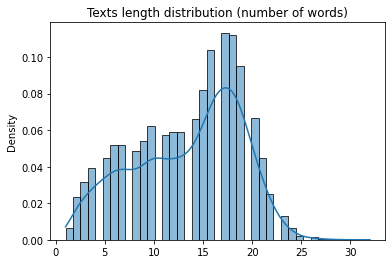

In [ ]:
text_lengths = [len(t.split()) for t in train_texts]
ax = sns.histplot(data=text_lengths, kde=True, stat="density")
ax.set_title("Texts length distribution (number of words)");

In [ ]:
# Let's choose a cutoff of 25 words, since most texts are shorter than this.

### Chack label's imbalance

/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


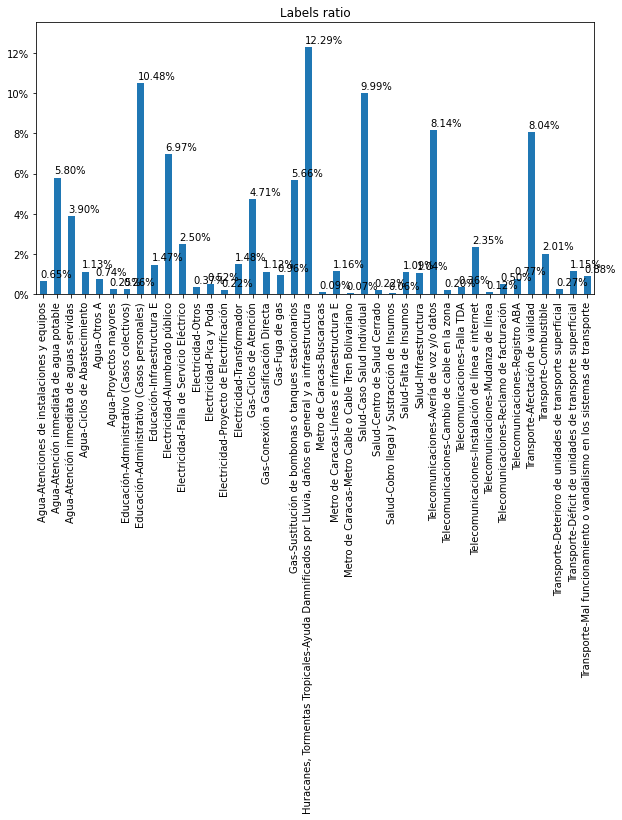

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(10, 5), constrained_layout=True)

# Labels distribution barplot
labels_ratio = dataset[label_names].mean()
labels_ratio.plot(kind="bar", ax=ax1)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=False))
for p in ax1.patches:
    ax1.set_ylim(0, 1.1 * labels_ratio.max())
    ax1.annotate(f"{p.get_height():.2%}", (p.get_x() + 0.005, p.get_height() + 0.002))
ax1.set_title("Labels ratio");

# Labels correlation heatmap
#ax2 = sns.heatmap(dataset[label_names].corr())
#ax2.set_title("Labels correlation")
fig.show()

For benchmark purpose it is always useful to know the performance of a dummy classifier that always predicts the label ratio as the label probability. Note that for multi-label classification we make a distinction between the accuracy (all predicted labels are correct) and the binary accuracy (how many individual labels are correct). The latter is always larger than the former because it is harder to predict all labels correctly. In the following I only compute the binary accuracy.

In [ ]:
dummy = DummyClassifier(strategy="prior")
dummy.fit(train_texts, train_labels)
y_pred = dummy.predict(test_texts)
y_prob = dummy.predict_proba(test_texts)
y_prob = np.array(y_prob)[:, :, 1].T

def compute_metrics(y_true: np.array, y_prob: np.array) -> pd.Series:
    """Compute several performance metrics for multi-label classification. """
    y_pred = y_prob.round()
    metrics = dict()
    metrics["Multi-label accuracy"] = np.all(y_pred == y_true, axis=1).mean()
    metrics["Binary accuracy"] = (y_pred == y_true).mean()
    metrics["Loss"] = log_loss(y_true, y_prob)
    metrics["Average Precision"] = average_precision_score(y_true, y_prob)
    return pd.Series(metrics)

evaluation = compute_metrics(test_labels, y_prob).to_frame(name="Dummy")
evaluation

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


,Dummy
Multi-label accuracy,0.000
Binary accuracy,0.975
Loss,3.005
Average Precision,NaN


### Setting a baseline

Let's setup a baseline with a rather classic NLP modelling technique: a TF-IDF vectorization step followed by a regularized logistic regression. Despite its simplicity, this approach often give good results.

In [ ]:
# We take into account unigrams and bigrams that occur at least 10 times 
# in the train set, but less than 50 % of the time
tfidf = TfidfVectorizer(min_df=10, max_df=0.5, ngram_range=(1, 2))

# We set the (L2) regularization weight to 1/2 (inverse of C)
classifier = OneVsRestClassifier(LogisticRegression(C=2., max_iter=1000))

baseline = make_pipeline(tfidf, classifier)
baseline.fit(train_texts, train_labels)

y_prob = baseline.predict_proba(test_texts)

evaluation["Baseline"] = compute_metrics(test_labels, y_prob)
evaluation

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


,Dummy,Baseline
Multi-label accuracy,0.000,0.521
Binary accuracy,0.975,0.986
Loss,3.005,1.103
Average Precision,NaN,NaN


In [ ]:
print(f"Transformers package version: {transformers.__version__}")

Transformers package version: 4.25.1


In [ ]:
MODEL_NAME = 'distilbert-base-multilingual-cased'
MAX_LENGTH = 25  # We truncate anything after the 200-th word to speed up training

# The configuration is not needed if you don't have to customize the 
# network architecture. Here we will need it to replacee the output of the model
# with a multi-label prediction layer (i.e. sigmoid activations + binary cross-entropy
# instead of softmax + categorical cross-entropy of multi-class classification)
config = DistilBertConfig.from_pretrained(MODEL_NAME)

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)


train_encodings = tokenizer(train_texts, truncation=True, padding=True, 
                            max_length=MAX_LENGTH, return_tensors="tf")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, 
                           max_length=MAX_LENGTH, return_tensors="tf")

# Create TensorFlow datasets to feed the model for training and evaluation
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

# Tokenizer output example
#sample_text = "parte calle 2 alumbrado debido cayó bombillas..."
#tokenizer.decode(tokenizer(sample_text)["input_ids"])

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

'[CLS] parte calle 2 alumbrado debido cayó bombillas... [SEP]'

The "[CLS]" special token is prepended to each text and will be used for classification, and a "[SEP]" token is appended.

Note that thanks to BERT adding customizable special tokens, you can also take into account custom vocabularies that maybe specific to your dataset (e.g. domain-specific tags, or unusual characters with a specific meaning). To do so, you just have to add the following line:

tokenizer.add_special_tokens({"additional_special_tokens": ["[unused1]"]})

and map your custom symbols to "[unused1]" (or "[unused2]", ..., up to "[unused999]"). We won't need it here.

In [ ]:
# So we will fine-tune ~134M parameters on our dataset. That may sound like a lot, 
# and one may be concerned with overfitting risks, but BERT has proven very robust to fine-tuning.


### Model training

In [ ]:
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)


Epoch 1/10
795/795 [==============================] - 2630s 3s/step - loss: 0.0111 - multi_label_accuracy: 0.9155 - binary_accuracy: 0.9967 - average_precision: 0.8301 - val_loss: 0.0468 - val_multi_label_accuracy: 0.7057 - val_binary_accuracy: 0.9871 - val_average_precision: 0.4796
Epoch 2/10
795/795 [==============================] - 2632s 3s/step - loss: 0.0086 - multi_label_accuracy: 0.9386 - binary_accuracy: 0.9976 - average_precision: 0.8868 - val_loss: 0.0506 - val_multi_label_accuracy: 0.7078 - val_binary_accuracy: 0.9872 - val_average_precision: 0.4587
Epoch 3/10
795/795 [==============================] - 2609s 3s/step - loss: 0.0069 - multi_label_accuracy: 0.9519 - binary_accuracy: 0.9981 - average_precision: 0.9112 - val_loss: 0.0528 - val_multi_label_accuracy: 0.7075 - val_binary_accuracy: 0.9873 - val_average_precision: 0.4830
Epoch 4/10
795/795 [==============================] - 2593s 3s/step - loss: 0.0056 - multi_label_accuracy: 0.9613 - binary_accuracy: 0.9985 - averag

### Deployment and tracking

**Configure MLflow**

In [ ]:
#!pip install mlflow --quiet
mlflow_installed = !pip list -v | grep mlflow
if not mlflow_installed:
  print("Installing MLflow")
  !pip install mlflow --quiet

import mlflow
import requests
import os
from getpass import getpass
import datetime

In [ ]:
#@title Enter the repository name for the project:

REPO_NAME= "VenApp-GroupProblems-AI" #@param {type:"string"}

In [ ]:
#@title Enter the repository Owner for the project:

REPO_OWNER= "arbozaleon" #@param {type:"string"}

In [ ]:
#@title Enter the username of your DAGsHub account:

USER_NAME = "arbozaleon" #@param {type:"string"}

**Set Local Configurations**

In [ ]:
# start the mlflow ui
#!mlflow ui

In [ ]:
#@title Version Data and Code

!pip install dvc

**Set Dagshub as remote storage**

In [ ]:
!dvc remote add origin https://dagshub.com/arbozaleon/VenApp-GroupProblems-AI.dvc

In [ ]:
import IPython

## Configure a Tensorflow Model

In [ ]:
transformer_model = TFDistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, output_hidden_states=False
)

bert = transformer_model.layers[0]

# The input is a dictionary of word identifiers 
input_ids = Input(shape=(MAX_LENGTH,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Here we select the representation of the first token ([CLS]) for classification
# (a.k.a. "pooled representation")
bert_model = bert(inputs)[0][:, 0, :] 

# Add a dropout layer and the output layer
dropout = Dropout(config.dropout, name='pooled_output')
pooled_output = dropout(bert_model, training=False)
output = Dense(
    units=train_labels.shape[1],
    kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
    activation="sigmoid",  # Choose a sigmoid for multi-label classification
    name='output'
)(pooled_output)

model = Model(inputs=inputs, outputs=output, name='BERT_MultiLabel')
model.summary()

In [ ]:
loss = BinaryCrossentropy()
optimizer = Adam(5e-5)
metrics = [
    multi_label_accuracy,
    "binary_accuracy", 
    AUC(name="average_precision", curve="PR", multi_label=True)
]
 
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
training_history = model.fit(
    train_dataset.shuffle(1000).batch(16), epochs=10, batch_size=16, 
    validation_data=test_dataset.batch(16)
)

**Benchmark model with Dummy and LogReg**

In [ ]:
benchmarks = model.evaluate(
    test_dataset.batch(16), return_dict=True, batch_size=16
)
evaluation["DistillBERT"] = [
    benchmarks[k] for k in 
    ["multi_label_accuracy", "binary_accuracy", "loss", "average_precision"]
]
evaluation

**Save Model**

In [ ]:
BASE_PATH = "/content/drive/MyDrive/VENAPP_CLASIF_CASOS/MODEL_BERT"

if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)

model.save(f"{BASE_PATH}/fine_tuned_distilbert")

**Inferencias**

In [ ]:
# Mimicking a production scenario: load the model and tokenizer
MAX_LENGTH = 25
model = load_model(f"{BASE_PATH}/fine_tuned_distilbert", 
                   custom_objects={"multi_label_accuracy": multi_label_accuracy})
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-multilingual-cased')

def score_text(text, model=model, tokenizer=tokenizer):
    padded_encodings = tokenizer.encode_plus(
        text,
        max_length=MAX_LENGTH, # truncates if len(s) > max_length
        return_token_type_ids=True,
        return_attention_mask=True,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    return model(padded_encodings["input_ids"]).numpy()

score_text("dummy")  # running a dummy prediction as a work-around the extra latency 
# of the first prediction of a loaded TensorFlow model.

#text = """Requerimos restablecer servicio eléctrico, se cayó un árbol y tumbó un poste"""

#text = """Vinieron a arreglar las aguas servidas y rompieron la tubería de gas, quedamos sin ese servicio"""

#text = """Necesito un trabajo, soy padre de familia desempleado"""

# text = """Quedamos sin ABA y sin línea, un árbol cayó y rompió cable"""

#text = """solicitud tensiómetros ambulatorios cdi hermanos ollarves reparación servicio rx 
#sra coromoto líquido revelador películas rx además ambulancia cdi cero"""

# text = """buenos días nuevamente tememos colapso cloaca"""

text = """llevamos varias horas a oscuras, al parecer a causa de caída de tabaco"""

#text = """nombre lucidio mujica ci 2543086 adulto mayor requiero unas prótesis dentales tel cont 04164523825"""
# text = """final av arismendi dinde encuentra escuela san vicente final callejon 
# hace falta buena asfaltada tambien estan afectados linea camionetas"""

t0 = time()
scores = score_text(text)[0]
latency = time() - t0

scores_pd = pd.Series(scores, label_names, name="scores")

# Find the maximum score
max_score = scores_pd.max()

# Find the text with the maximum score
max_score_text = scores_pd[scores_pd == max_score].idxmax()
result = max_score_text.split('-')

#print(scores_pd.to_frame())
#print(f"Category: {max_score_text} \nLatency: {latency:.3f} seconds")
print(f"Category: {result[0]} \nExtra-Category: {result[1]} \nLatency: {latency:.3f} seconds")

## Set MLflow Auto-Logging

In [ ]:
 mlflow.tensorflow.autolog()
 mlflow.log_param("task",2)

## See the Experiment Results - LIVE! 📳

In this tab, you can see the results of the experiment while it's running!

**Notice**: To update the experiment status, simply go back to the "Experiment Tab" and reopen the top experiment in the table.

In [ ]:
display(IPython.display.IFrame(f"https://dagshub.com/{REPO_OWNER}/{REPO_NAME}/experiments/#/",'100%',600))

## Train the Model

In [ ]:
model.fit(X_train, y_train, batch_size= 32, validation_split=0.2, epochs=50,verbose=0)